# Topological Measures of Geographical Surfaces

[*Levi John Wolf*](https://github.com/ljwolf)

In [1]:
import geopandas, numpy
import matplotlib.pyplot as plt
from esda import topo
from libpysal import weights

This notebook explains the usage and meaning of the `topo` functions, `prominence` and `isolation`. Both of these concepts arise from *topography*, the study of the forms and features of a surface. 

In this sense, topographical measures focus on the shape of a surface. In physical geography, `prominence` and `isolation` are both topographical measures that refer to how high (or how "dominant") a mountain is relative to its landscape. Mathematically, if we represent "elevation" with a surface (like a Digital Elevation Model, or DEM), then this becomes a way to characterize the local maxima, minima, and/or saddle points of a given surface. In this way, `prominence` (and `isolation`) are intricately connected to the local extrema and concavity/convexity of a surface, and provide useful ways to think about the structure of a geographical distribution. In a physical sense, the `isolation` of a mountain peak is *the distance you have to travel to find a higher point on the surface.* So, the common example given, say, on Wikipedia, is that Mount Everest has an "infinite" isolation, since it is the highest point on Earth's surface. The nearby peak K2, the second-highest mountain on Earth is relatively close to Everest, so K2 has quite a low isolation. However, Aconcauga, the tallest peak in the Western Hemisphere, is about 1,000 meters shorter than K2, but *way more isolated*, since the distance from it to the nearest highest point is very large. So, `isolation` is a measure of *horizontal* distance. 

In contrast, `prominence` is a measure of *vertical* distance, describing the *gap between the peak's elevation and the "highest" low point between it and its parent peak*. Conceptually, imagine that the whole world is flooded, all the way to the top of Mount Everest. Let's denote the height of mountain $i$ as $h_i$, and the water level as $w$. So, starting with $max(h_i) = w$, we lower the water. When $h_i = w$, a peak "emerges" from the water. Imagine two peaks of height $h_i$ and $h_j$ (such that $h_i > h_j$). Then, imagine that $w$ falls to a point $w^* < h_j < h_i$ where $h_i$ and $h_j$ become "connected" together as part of a single landmass. Then, the *prominence* of $h_j$ is computed as $p_j = h_i - w^*$, the *relative* height between peak $j$ and the lowest point connecting $j$ and $i$. In this model, it makes sense to *then* consider $j$ and $i$ the same peak $(ij)$, and measure the next peak's prominence as the lowest point between $k$ and $(ij)$. We use `prominence` because it tells you how high a peak/local maxima is *relative* to its surroundings. 

Things are complicated somewhat when we're dealing with irregular or dis-continuous relief. When dealing with mountains and elevation, we know that elevation is a *surface* that changes (relatively) smoothly. In contrast, most of our *vector* data does not change smoothly. Despite this, we can still use these notions of `isolation` and `prominence` to measure the relative contrasts between parts of a geographcial surface. 

So, for what happens next, we'll refer to the natural earth dataset baked into `geopandas`. We'll use the population estmate (`pop_est`) as a kind of "elevation," *a la* [@undertheraedar](https://twitter.com/undertheraedar)'s excellent population topography: 

![this is a picture of global population like it's a surface](https://pbs.twimg.com/media/Ej0HeVoXsAEmShV?format=jpg&name=4096x4096)

## Isolation and Prominence of country populations

Let's start with a natural example: isolation of population of countries. 

In [2]:
natearth = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

To start, we know that China, India, and the US are the three most populous countries in the world: 

In [3]:
natearth.sort_values('pop_est', ascending=False).head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
139,1379302771,Asia,China,CHN,21140000.0,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ..."
98,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711 28.26158, 97.40256 27.88254..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
8,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."


This is a perfect dataset to think about isolation/prominence, since we have big gaps between the highest population points in each continent. 

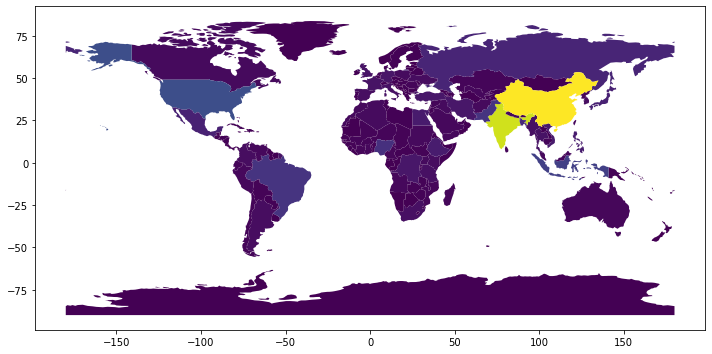

In [4]:
f,ax = plt.subplots(1,1,figsize=(12,6))
natearth.plot('pop_est', ax=ax)

To simplify things, we'll just consider the Euclidean distances between country centroids, but we could (in theory) use any kind of distance we want in this function by specifying the `metric` argument. 

In [5]:
coordinates = numpy.column_stack((natearth.centroid.x, natearth.centroid.y))

<ipython-input-5-c7f3e5869dee>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coordinates = numpy.column_stack((natearth.centroid.x, natearth.centroid.y))


To get a bit more information on the result, we can use `return_all` to get the rank and distance for the isolated peak. This also returns the gap between the peak and its nearest higher peak. 

In [6]:
iso = topo.isolation(natearth.pop_est, coordinates, return_all=True)

Under the hood, this algorithm uses `rtree` and `numpy.sort` to insert observations into a `SpatialIndex()` in rank-order. Iterating down the ranks, the nearest higher observation is found in the `SpatialIndex()`, and that becomes the parent of that observation.  As we iterate, `pop_est` gets smaller and smaller, and more and more entries are added to the `rtree`. 

Merging this back to the data we have will let us visualize it. 

In [7]:
natearth = (natearth.merge(iso, left_index=True, right_index=True)
           )

So, you can see that the *isolation* for China is infinite, since there is no country with a larger population. However, the isolation for India is only the distance from China to India (27). The isolation for the US, however, is much larger, and reflects the distance from the US to India (which just happens to be closer than China). The fourth-most populous country, Indonesia, is closer to China than India, so its `parent_rank` is 0, and its `isolation` is the distance from Indonesia to China. Last, you see Brazil, 5th most populous country, has US as a parent, with an isolation `distance` of 82. 

In [8]:
natearth[['continent', 'name', 'rank', 
          'pop_est', 'parent_rank', 'isolation',
          'gap']].sort_values('pop_est', ascending=False).head()

,continent,name,rank,pop_est,parent_rank,isolation,gap
139,Asia,China,0.0,1379302771,NaN,NaN,NaN
98,Asia,India,1.0,1281935911,0.0,27.852795,9.736686e+07
4,North America,United States of America,2.0,326625791,1.0,193.538522,9.553101e+08
8,Asia,Indonesia,3.0,260580739,0.0,41.072699,1.118722e+09
29,South America,Brazil,4.0,207353391,2.0,82.093057,1.192724e+08


Visualizing this below, we get the following:

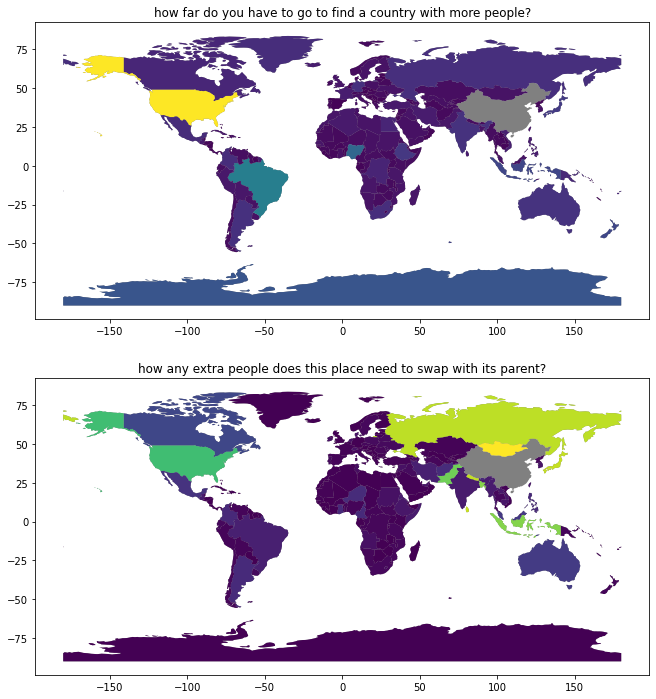

In [9]:
f,ax = plt.subplots(2,1,figsize=(12,12))
for i in range(2):
    natearth.plot(color='grey', ax=ax[i])
natearth.plot('isolation', ax=ax[0])
natearth.plot('gap', ax=ax[1])
ax[0].set_title('how far do you have to go to find a country with more people?')
ax[1].set_title('how any extra people does this place need to swap with its parent?')
plt.show()

Next, to see `prominence`, we'll use the same arguments. However, `prominence` can also take a graph/`libpysal.weights.W` object that specifies the connections between sampled locations. If no pre-existing graph or surface is provided, the Delaunay Triangulation is used between the coordinates provided, which is a common triangulation in digital elevation models. Here, I'll use the Rook contiguity graph, just for ease of interpretation. This means that some islands will automatically be considered as "peaks" because they don't share any borders with any higher observations. 

In [10]:
w_rook = weights.Rook.from_dataframe(natearth)
prominence = topo.prominence(natearth.pop_est, w_rook, return_all=True)

/home/lw17329/anaconda3/envs/analysis/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 25 disconnected components.
 There are 21 islands with ids: 0, 19, 20, 22, 23, 45, 46, 47, 78, 89, 134, 135, 136, 137, 138, 140, 144, 147, 155, 159, 175.
  warnings.warn(message)


Under the hood, this algorithm may take a bit longer for big data, so you can use the `progressbar` option to visualize the progress. 

The actual algorithm entails sorting the data and determining whether we "connect" peaks together each time we introduce a new observation as equal to the declining sea level $w$. We *avoid* re-computing `scipy.sparse.connected_components` each iteration by creating a `set` of neighbors for each "peak." When two (or more) peaks merge, we replace the independent peaks `i` and `j` (where $h_i > h_j$) with peak `(i,j)`. Each merge, the new peak gets the union of the sub-peaks neighbors, and are then treated as a single "peak" from then on. 

We merge it back onto our data in the same fashion as before: 

In [11]:
natearth = natearth.merge(prominence, left_index=True, right_index=True, suffixes=("","_prom"))

This gives us the following table. I'm going to show a bit more rows than usual so we can interpret it more clearly. 

In [12]:
natearth[['continent', 'name', 'pop_est', 
          'rank', 'parent_rank', 'isolation',
          'dominating_peak', 'keycol', 'prominence']].sort_values('pop_est', ascending=False).head(20)

,continent,name,pop_est,rank,parent_rank,isolation,dominating_peak,keycol,prominence
139,Asia,China,1379302771,0.0,NaN,NaN,139,93,1.324179e+09
98,Asia,India,1281935911,1.0,0.0,27.852795,139,-1,NaN
4,North America,United States of America,326625791,2.0,1.0,193.538522,139,33,3.228726e+08
8,Asia,Indonesia,260580739,3.0,0.0,41.072699,4,148,2.291987e+08
29,South America,Brazil,207353391,4.0,2.0,82.093057,8,43,1.402472e+08
102,Asia,Pakistan,204924861,5.0,1.0,12.381725,139,-1,NaN
56,Africa,Nigeria,190632261,6.0,4.0,64.353456,29,55,1.713869e+08
99,Asia,Bangladesh,157826578,7.0,1.0,10.713323,139,-1,NaN
18,Europe,Russia,142257519,8.0,0.0,26.374718,139,-1,NaN
155,Asia,Japan,126451398,9.0,0.0,34.199305,56,-1,1.264513e+08


These are the top 20 countries in terms of population. Walking down the rows, you see that China has a isolation of `NaN` and a prominence that is exactly equal to its population. India shares a border with China. So, when we "lower the sea level" to where India emerges from the water level, it's already connected to the highest peak, China. So, its *prominence* is not very large. In fact, it's considered a "slope" of the "China" mountain, and its `dominating_peak` is 139, the index for "China." However, the US's prominence is (confusingly) computed as the height relative to the population of Panama, sin ce Panama connects it to Sough America, where French Guyana then connects between NA/SA and Eurasia in this graph. Indonesia, likewise, has a prominence measured starting from Malaysia, which connects it to Asia, where it encounters the China-based subgraph. 

For a visual on what the "key-cols" are, we're thinking about the points at which the disconnected countries become connected in the following sequences of graphs. In each graph, only the "red" outlined countries are above the "water line" $w$. 

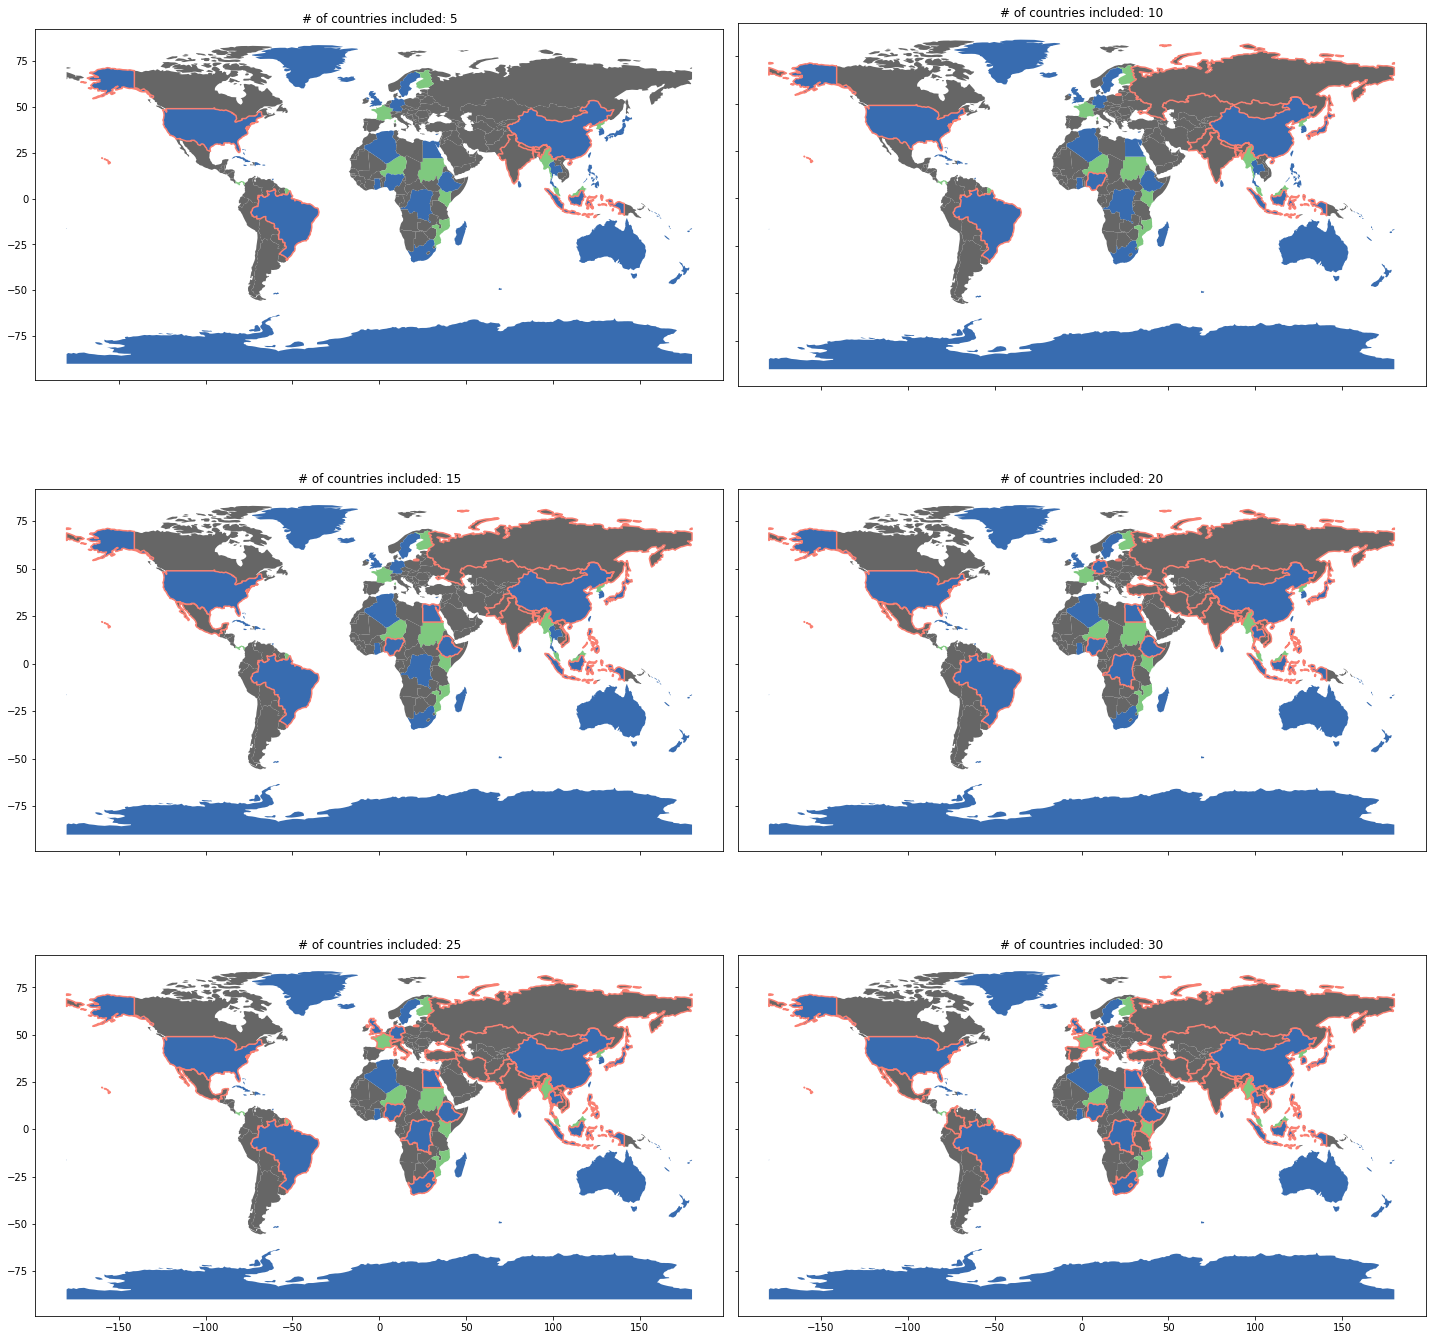

In [13]:
f,ax = plt.subplots(3,2, figsize=(20,20), sharex=True, sharey=True)
ax=ax.flatten()
for ix, rank in enumerate(range(5,31, 5)):
    natearth.plot('classification', ax=ax[ix], cmap='Accent')
    natearth.sort_values('pop_est', ascending=False).iloc[0:rank].boundary.plot(color='salmon', ax=ax[ix])
    ax[ix].set_title(f"# of countries included: {rank}")
f.tight_layout()
plt.show()

You can see that the first "key col" country, France, is included around the 25-country mark, wheras before that most included countries are "peaks," disconnected from one another. Below, you can see the full map of classifications, alongside the prominence of each country.  

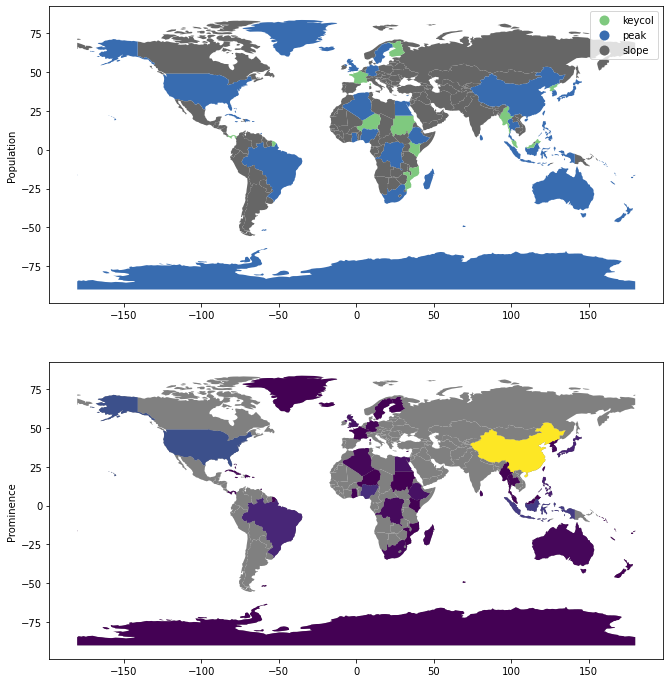

In [14]:
f,ax = plt.subplots(2,1,figsize=(12,12))
natearth.plot('classification', ax=ax[0], legend=True, cmap='Accent')
natearth.plot(color='grey', ax=ax[1])
natearth.plot('prominence', ax= ax[1])
ax[0].set_ylabel('Population')
ax[1].set_ylabel('Prominence')
plt.show()